# **Introduction**

***Howdy, Welcome to the Titanic***

**To whom does this notebook appeal to?**<br><br>
If you are just starting with WNNC's HELLO FOSS and want to do beginner task in ML, I suggest you start here!

Run this notebook once and you can see the accuracy of this model is mere 61% :(

Data reading, visualization and pre-processing has been done for you. We need you to tune the hypreparameters so as to improve its accuracy and bring it above **80%**. Head over to [this cell](#main) to make the nececsaary changes. Afterwards graphically visualise your training and validation accuracy with each epoch [here](#main2).

![](https://faithmag.com/sites/default/files/styles/article_full/public/2018-09/titanic2.jpg?h=6521bd5e&itok=H8td6QVv)

**Basic Imports**

In [283]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import os
files = [f for f in os.listdir('./titanic/')]
for f in files:
        print(f)



train.csv
gender_submission.csv
grader.py
test.csv
output.csv


# Reading In the Data

We will be first importing the data, and creating copies. I recommend this because it give you access to a clean untouched base file.
Next, we will be dropping some things that we don't need such as passenger Id and Ticket price

In [284]:
train_data = pd.read_csv('./titanic/train.csv')
test_data = pd.read_csv('./titanic/test.csv')
#make a copy so your original data is not touched
train = train_data.copy()
test = test_data.copy()
train.shape
y_train = train['Survived']

#We won't need passenger ID or ticket price for the model! They do not provide much insight on the training.
Id = pd.DataFrame(test['PassengerId'])
train.drop(['PassengerId'], axis = 1, inplace=True)
test.drop(['PassengerId'], axis = 1, inplace=True)
train.drop(['Survived'], axis = 1, inplace=True)
train.drop(['Ticket'], axis = 1, inplace=True)
test.drop(['Ticket'], axis = 1, inplace=True)

**Let's take a look at our data!**

In [285]:
train.head()

Pclass                                               Name  ... Cabin  Embarked
0       3                            Braund, Mr. Owen Harris  ...   NaN         S
1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  ...   C85         C
2       3                             Heikkinen, Miss. Laina  ...   NaN         S
3       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  ...  C123         S
4       3                           Allen, Mr. William Henry  ...   NaN         S

[5 rows x 9 columns]

**Lets see how many null values there are! We need to fill out these values later.**

**We see that we have some midding values from age, and a ton missing from cabin**

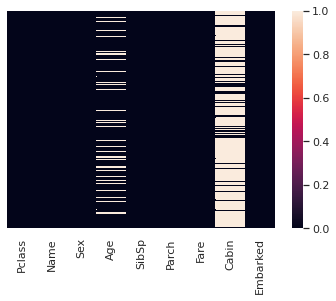

In [286]:
sns.heatmap(train.isnull(),yticklabels=False,cbar='BuPu')


In [287]:
train.isnull().sum().sort_values(ascending=False)[0:20]
# we can see that cabin is midding a lot of values, and age is tooi!

Cabin       687
Age         177
Embarked      2
Fare          0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
dtype: int64

# **Data Cleaning**

**This is an awesome function I created that preprocesses the data. It does thes following**

* Fills in null values based on mean or mode
* Drops columns that are missing 50 percent of the data

*You guys are free to copy this for loop for your own projects!*[](http://)

In [288]:


#clean the train data
for i in list(train.columns):
    dtype = train[i].dtype
    values = 0
    if(dtype == float or dtype == int):
        method = 'mean'
    else:
        method = 'mode'
    if(train[i].notnull().sum() / 891 <= .5):
        train.drop(i, axis = 1, inplace=True)
    elif method == 'mean':
        train[i]=train[i].fillna(train[i].mean())

    else:
        train[i]=train[i].fillna(train[i].mode()[0])

# WE CAN DO THIS FOR THE TEST SET TOO!

#clean the test data
for i in list(test.columns):
    dtype = test[i].dtype
    values = 0
    if(dtype == float or dtype == int):
        method = 'mean'
    else:
        method = 'mode'
    if(test[i].notnull().sum() / 418 <= .5):
        test.drop(i, axis = 1, inplace=True)
    elif method == 'mean':
        test[i]=test[i].fillna(test[i].mean())

    else:
        test[i]=test[i].fillna(test[i].mode()[0])




**As we can see, all of the missing values are gone!**

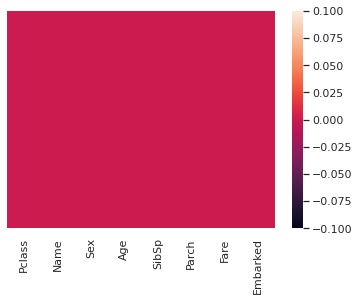

In [289]:
sns.heatmap(train.isnull(),yticklabels=False,cbar='BuPu')


# **Feature Engineering**

**Title**

Lets take out the Mr, Miss, etc from the name section, and create a new column names title!

In [290]:
#TITLE

train_test_data = [train, test] # combining train and test dataset

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 1, 
                 "Master": 0, "Dr": 1, "Rev": 0, "Col": 0, "Major": 0, "Mlle": 1,"Countess": 1,
                 "Ms": 1, "Lady": 1, "Jonkheer": 1, "Don": 0, "Dona" : 1, "Mme": 0,"Capt": 0,"Sir": 0 }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    


**Sex**


We can make male and female into catagorical variables such as 0 and 1

In [291]:
    
sex_mapping = {"male": 0, "female":1}
for dataset in train_test_data:
      dataset['Sex'] = dataset['Sex'].map(sex_mapping)


**Embarked**

Lets test to see if there is any correlation with Pclass and Embarked 

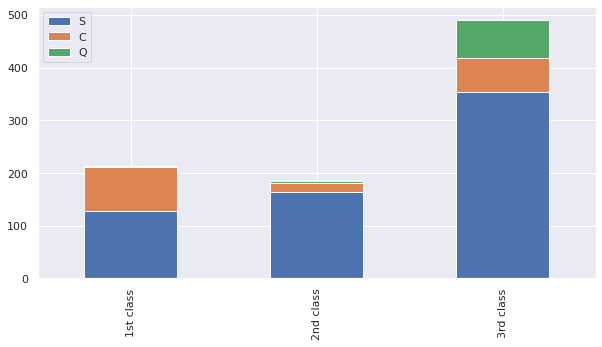

In [292]:
Pclass1 = train_data[train_data['Pclass'] == 1]['Embarked'].value_counts()
Pclass2 = train_data[train_data['Pclass'] == 2]['Embarked'].value_counts()
Pclass3 = train_data[train_data['Pclass'] == 3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

We can assign each embarked value to a numberical value for training later!

In [293]:
for data in train_test_data:
    data['Embarked'] = data['Embarked'].fillna("S")
    
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

**Family Size**

Parch ( Parent & child ) and Sibsp( Sibling & Spouse ) are both contributing factors to family size, so lets make a new column called family size, and drop the other ones.

In [294]:
train["FamilySize"] = train['SibSp'] + train['Parch'] + 1
test["FamilySize"] = test['SibSp'] + test['Parch'] + 1

# **Correlations**

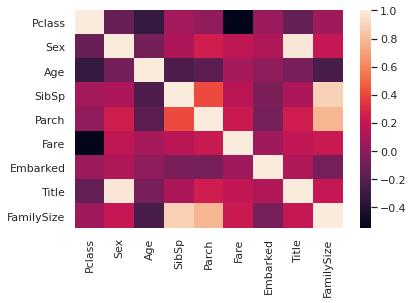

In [295]:
sns.heatmap(train.corr(),cbar='plasma')


In [296]:
train.drop(['Name'], axis = 1, inplace=True)
test.drop(['Name'], axis = 1, inplace=True)

In [297]:
train.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title  FamilySize
0       3    0  22.0      1      0   7.2500         0      0           2
1       1    1  38.0      1      0  71.2833         1      1           2
2       3    1  26.0      0      0   7.9250         0      1           1
3       1    1  35.0      1      0  53.1000         0      1           2
4       3    0  35.0      0      0   8.0500         0      0           1

In [298]:
test.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title  FamilySize
0       3    0  34.5      0      0   7.8292         2      0           1
1       3    1  47.0      1      0   7.0000         0      1           2
2       2    0  62.0      0      0   9.6875         2      0           1
3       3    0  27.0      0      0   8.6625         0      0           1
4       3    1  22.0      1      1  12.2875         0      1           3

# **PreProcessing**

**Now that our data looks good, lets get ready to build our models!**

In [299]:
#imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

We should scale the values in the data, so that the neural network can train better!

In [300]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'FamilySize']

scaler = StandardScaler()

for var in continuous:
    train[var] = train[var].astype('float64')
    train[var] = scaler.fit_transform(train[var].values.reshape(-1, 1))
for var in continuous:
    test[var] = test[var].astype('float64')
    test[var] = scaler.fit_transform(test[var].values.reshape(-1, 1))

In [301]:
train.describe(include='all').T


count          mean       std  ...       50%       75%       max
Pclass      891.0 -2.031048e-16  1.000562  ...  0.827377  0.827377  0.827377
Sex         891.0  3.524130e-01  0.477990  ...  0.000000  1.000000  1.000000
Age         891.0  2.562796e-16  1.000562  ...  0.000000  0.407926  3.870872
SibSp       891.0  3.456519e-16  1.000562  ... -0.474545  0.432793  6.784163
Parch       891.0  6.716164e-17  1.000562  ... -0.473674 -0.473674  6.974147
Fare        891.0 -4.373606e-17  1.000562  ... -0.357391 -0.024246  9.667167
Embarked    891.0  3.613917e-01  0.635673  ...  0.000000  1.000000  2.000000
Title       891.0  3.591470e-01  0.480020  ...  0.000000  1.000000  1.000000
FamilySize  891.0  2.502051e-16  1.000562  ... -0.560975  0.059160  5.640372

[9 rows x 8 columns]

# **Neural Network**

<a id='main'></a>
Here's the model! 

In [324]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D,MaxPool2D
from keras.wrappers.scikit_learn import KerasClassifier

tf.keras.optimizers.Adam(
    learning_rate=0.05, name='adam',
)
#creating a model with sequential columns
model = Sequential()

#flattens the data into a 1d array
model.add(Flatten())
#creates the first latyer with the input dimanetion. 

model.add(Dense(16, input_dim=train.shape[1],kernel_initializer = 'uniform', activation='relu'))
#next layer with 32 dense nodes
model.add(Dense(8, kernel_initializer = 'uniform', activation = 'tanh'))

#last layer is initiated here
model.add(Dense(4,kernel_initializer = 'uniform', activation = 'relu'))

# create output layer
    # Feel free to experiment with the activation functions and the optimizers
model.add(Dense(1, activation='sigmoid'))  # output layer
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


**Let's fit our model!**

In [325]:
history = model.fit(train, y_train, epochs=20, batch_size=10, validation_split = 0.2)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

72/72 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6096 - val_loss: 0.6679 - val_accuracy: 0.6425
Epoch 2/20
72/72 [==============================] - 0s 1ms/step - loss: 0.6362 - accuracy: 0.6292 - val_loss: 0.5552 - val_accuracy: 0.8101
Epoch 3/20
72/72 [==============================] - 0s 1ms/step - loss: 0.5451 - accuracy: 0.7879 - val_loss: 0.4498 - val_accuracy: 0.8324
Epoch 4/20
72/72 [==============================] - 0s 1ms/step - loss: 0.4825 - accurac

In [326]:
print(model.summary())


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_55 (Flatten)         (None, 9)                 0         
_________________________________________________________________
dense_250 (Dense)            (None, 16)                160       
_________________________________________________________________
dense_251 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_252 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_253 (Dense)            (None, 1)                 5         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
None


**Evaluate the model!**

In [327]:
scores = model.evaluate(train, y_train, batch_size=32)

28/28 [==============================] - 0s 877us/step - loss: 0.4130 - accuracy: 0.8350


**Create Predictions**

In [328]:
y_pred = model.predict(test)

y_final = (y_pred > 0.5).astype(int).reshape(test.shape[0])

output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': y_final})
output.to_csv('prediction-ann.csv', index=False)

# **Neural Network Analyasis**

<a id='main2'></a>
We can plot the loss, and val_loss & acc and val_acc
The main purpose of this is to make sure the model follows a good trend, and to make sure that you are not overfitteing your model.

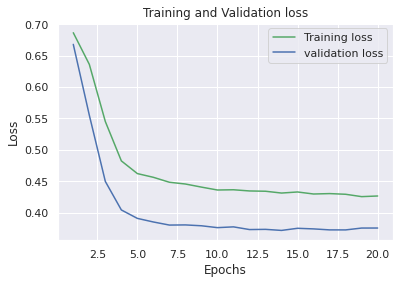

In [329]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()